In [87]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import cv2


In [88]:
from typing import Any, Tuple

In [89]:
class MyDataset(Dataset):
    def __init__(self, path_to_annot_file: str, transform: Any=None, train: bool=None, test: bool=None, valid: bool=None) -> None:
        self.path_to_annot_file = path_to_annot_file
        self.data = self.get_data(path_to_annot_file, train, test, valid)
        self.transform = transform

    def get_data(self, path_to_annot_file: str, train: bool=None, test: bool=None, valid: bool=None):
        data = pd.read_csv(path_to_annot_file, usecols = (0, 2), names = ('path_to_image', 'label'))
        data = data.sample(frac=1).reset_index(drop=True)
        data['label'] = data['label'].apply(lambda label: 0 if label == 'polarbear' else 1)
        train_size = int(0.8 * data.shape[0])
        test_valid_size = int(0.1 * data.shape[0])
        if train == True:
            data = data.iloc[:train_size, :]
        elif test == True:
            data = data.iloc[train_size:train_size + test_valid_size, :]
        elif valid == True:
            data = data.iloc[train_size + test_valid_size:, :]
        return data

    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        path_to_image = self.data.iloc[index, 0]
        image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
        label = self.data.iloc[index, 1]

        if self.transform:
            image = self.transform(image)
        
        return image, label


In [90]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize((224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [91]:
train_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, train = True)
test_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, test = True)
valid_data = MyDataset(path_to_annot_file='paths.csv', transform=transforms, valid = True)

In [92]:
len(train_data), len(test_data), len(valid_data)

(1604, 200, 202)

In [93]:
train_data.data['label'].value_counts()

label
1    808
0    796
Name: count, dtype: int64

In [94]:
test_data.data['label'].value_counts()

label
1    109
0     91
Name: count, dtype: int64

In [95]:
valid_data.data['label'].value_counts()

label
1    107
0     95
Name: count, dtype: int64

In [96]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                                stride = 2)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                stride = 2)
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                                stride = 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fully_connect1 = nn.Linear(576, 10)
        self.fully_connect2 = nn.Linear(10, 1)

    def forward(self, x:torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = self.relu(self.conv_3(output))
        output = self.max_pool(output)

        output = torch.nn.Flatten()(output)
        output = self.relu(self.fully_connect1(output))
        output = torch.nn.Sigmoid()(self.fully_connect2(output))
        return output

In [82]:
batch_size = 4

In [83]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle = True)

C:\Users\WWolk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for 

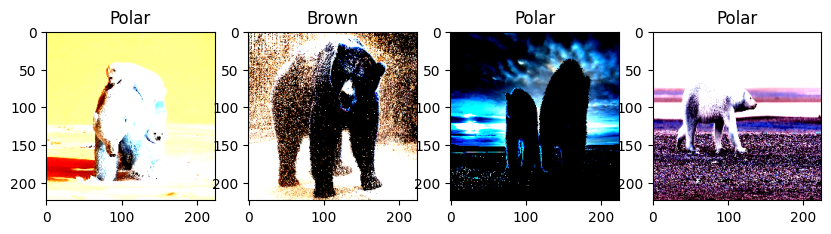

In [97]:
plt.figure(figsize = (10, 5))

for i, sample_batched in enumerate(train_loader):
    if i == 1:
        break
    for j in range(batch_size):
        plt.subplot(1, 4, j + 1)
        plt.title('Polar' if sample_batched[1][j] == 0 else 'Brown')
        plt.imshow(sample_batched[0][j].permute(1, 2, 0).numpy()[:, :, ::-1])